In [11]:
# Imports
import scipy.special as sp         # Special functions
import scipy.integrate as intg     # Integration package
import numpy as np                 # Ye olde numpy
import matplotlib.pyplot as plt    # Ye olde plt
import mpmath                      # This allows arbitrary precision
from mpmath import mpc             # Complex numbers
from mpmath import mp              # Number representation parameter control

## Focused LG-Beam class
### $\mathbf{E} = \frac{1}{2}\mathbf{E}_{pl, 0}(\alpha, \beta) + \frac{1}{4} \mathbf{E}_{pl, -2}(\alpha + i\beta, i\alpha - \beta) + \frac{1}{4} \mathbf{E}_{pl, 2}(\alpha - i\beta, -i\alpha - \beta)$
Check $*$ markdown at the end of this notebook for parameters

In [13]:
class LGBeam:
    # Specification parameters
    p, l = 0, 2                 # Regards Laguerre function parameters
    alpha, beta = 1, 0          # Polarization parameters (x-polarization means (alpha, beta) = (1, 0))
    r_focus = 1E-3              # Rayleigh focus (lens parameter)
    wavelength = 6238E-9        # 6238nm is He-Ne laser's wavelength
    na = .95                    # Numerical aperture [NA]
    # Derived parameters
    k = 2 * np.pi / wavelength  # Wave-number
    w0 = 3.2 * wavelength       # Beam-waist radius (Gaussian parameter)
    s = 1 / k / w0              # Beam-waist parameter
        
    
    def __init__(self, *args, **kwargs):
        # Note this only admits any parameter if all others are specified yet
        if kwargs:
            self.p = kwargs["p"]
            self.l = kwargs["l"]
            self.alpha = kwargs["alpha"]
            self.beta = kwargs["beta"]
            self.r_focus = kwargs["r_focus"]
            self.na = kwargs["na"]
            self.wavelength = kwargs["wavelength"]
        # Derived parameters 
        self.k = 2 * np.pi / self.wavelength
        self.w0 = 3.2 * self.wavelength
        self.s = 1 / self.k / self.w0
    
    # For conciseness in upcoming methods
    def a(self, u):
        return self.r_focus * self.s * np.sqrt(2) * u
    
    # For conciseness in upcoming methods
    def e_integrand_in(self, u, q):
        kz = mpmath.sqrt(self.k ** 2 - u ** 2)
        a = self.a
        result = u / mpmath.sqrt(self.k * kz) \
               * (1 + (1 - np.abs(q)) * kz / self.k) \
               * -1 ** self.p / self.w0 \
               * np.sqrt(2 / mpmath.pi * mpmath.gammaprod([self.p + 1],
                                         [self.p + np.abs(self.l) + 1])) \
               * a(u) ** np.abs(self.l) \
               * mpmath.laguerre(self.p, self.l, a(u) ** 2) \
               * mpmath.exp(-a(u) ** 2 / 2)
        return result
    
    # This is one of the E_{pl, q}(\alpha, \beta)
    def e_integrand(self, u, q, alpha, beta, r, theta, phi):
        kz = mpmath.sqrt(mpmath.power(self.k, 2) - mpmath.power(u, 2))
        result = self.e_integrand_in(u, q) \
               * mpmath.exp(1j * (self.l + q) * phi \
                          + 1j * kz * r * np.cos(theta)) \
               * ((alpha * np.cos(phi) + beta * np.sin(phi)) 
                 * np.sin(theta) \
                 * mpmath.besselj(self.l + q, r * np.sin(theta) * u) \
                 + u * np.cos(theta) / 2 / kz \
                 * ((1j * alpha - beta) * np.exp(-1j * phi) \
                   * mpmath.besselj(self.l + q - 1, r * np.sin(theta) * u) \
                   - (1j * alpha + beta) * np.exp(1j * phi) \
                   * mpmath.besselj(self.l + q + 1, r * np.sin(theta) * u)))
        return result
    
    # Part of integrand that depends on \eta
    def eta_integrand(self, u, *coords):
        a, b = self.alpha, self.beta
        return lgbeam.e_integrand(u, 0, a, b, *coords) / 2 \
            + lgbeam.e_integrand(u, -2, a + 1j * b, 1j * a - b, *coords) / 4 \
            + lgbeam.e_integrand(u, 2, a - 1j * b, -1j * a - b, *coords) / 4

    # Integrand for triple quadrature on (\eta, \theta, \phi)
    def triple_integrand(self, u, theta, phi, n, m):
        return self.eta_integrand(u, (n + .5) / self.k, theta, phi) \
            * sp.lpmv(np.abs(m), n, np.cos(theta)) \
            * np.exp(-1j * m * phi) * mpmath.sin(theta)
    
    # Real part [Re]
    def real_triple_integrand(self, *args, **kwargs):
        return mpmath.re(self.triple_integrand(*args, **kwargs))
    
    # Imaginary part [Im]
    def imag_triple_integrand(self, *args, **kwargs):
        return mpmath.im(self.triple_integrand(*args, **kwargs))
            
    # Re
    def real_triple_integral(self, n, m):
        return intg.tplquad(self.real_triple_integrand,
                            0, np.pi, 0, 2 * np.pi, 0, self.k * self.na,
                            args=(n, m))[0]
    
    # Im
    def imag_triple_integral(self, n, m):
        return intg.tplquad(self.imag_triple_integrand,
                            0, np.pi, 0, 2 * np.pi, 0, self.k * self.na,
                            args=(n, m))[0]
    
    # Re + i * Im
    def triple_integral(self, n, m):
        return self.real_triple_integral(n, m) \
            + 1j * self.imag_triple_integral(n, m)
    

In [76]:
# This might take a while... :(
lgbeam = LGBeam()
print(lgbeam.triple_integral(3, 1))

(-57469.84019816016-1.6376042936852142e-12j)


### The integrand in the triple quadrature integral is of the form:<br> $\mathcal{I}(\eta, \theta, \phi) = \left.E_r(\eta, \theta, \phi)\ P_n^{|m|}(\cos\theta)\ e^{-im\phi}\sin\theta\ \right|_{kr = R^{\text{loc}} = \left(n + \frac{1}{2}\right)}$
### Plotting the quadrature integrand for comparing with previous results:
In the cell below, we plot two slices at $\phi = \phi_0 = 0.15 \pi$ - one at $\theta = \pi / 2$ and the other at $\eta = \eta_{\text{max}}$, <br> where $\eta_{\text{max}}$ satisfies $\max\left\{ \mathcal{I}\left(\eta, \frac{\pi}{2}, \phi_0\right) \right\} = \mathcal{I}\left( \eta_{\text{max}}, \frac{\pi}{2}, \phi_0 \right)$

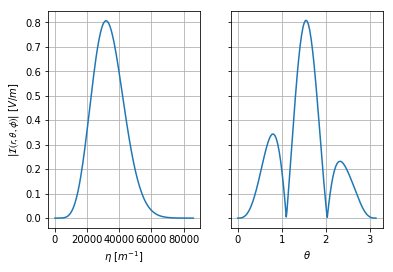

In [14]:
lgbeam = LGBeam()
n = lgbeam.l + 1
m = lgbeam.l - 1
r = (n + 1 / 2) / lgbeam.k
theta = np.pi / 2
phi = .15 * np.pi

# fld = lgbeam.field(r, theta, phi)
# dbl_integrand = fld * sp.lpmv(np.abs(m), n, np.cos(theta)) * np.exp(-1j * m * phi)
# print(mpmath.norm(dbl_integrand))
coords = r, theta, phi

def eta_integrand(u, *coords, lgbeam=lgbeam):
    a, b = lgbeam.alpha, lgbeam.beta
    return lgbeam.e_integrand(u, 0, a, b, *coords) / 2 \
        + lgbeam.e_integrand(u, -2, a + 1j * b, 1j * a - b, *coords) / 4 \
        + lgbeam.e_integrand(u, 2, a - 1j * b, -1j * a - b, *coords) / 4

def triple_integrand(u, n, m, r, theta, phi, lgbeam=lgbeam):
    return eta_integrand(u, r, theta, phi, lgbeam=lgbeam) \
        * sp.lpmv(np.abs(m), n, np.cos(theta)) \
        * np.exp(-1j * m * phi) * mpmath.sin(theta)

delta = .09
max_u = lgbeam.k * lgbeam.na * delta
us = np.linspace(0, max_u, 200)
ts = np.linspace(0, np.pi, 200)
fig, axes = plt.subplots(ncols=2, sharey=True)

ints = []
max_val = 0
peak_u = 0
for u in us:
    val = mpmath.norm(triple_integrand(u, n, m, *coords))
    if val >= max_val:
        max_val = val
        peak_u = u
    ints.append(val)

ints2 = []
for t in ts:
    val = mpmath.norm(triple_integrand(peak_u, n, m, r, t, phi))
    ints2.append(val)
    
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel("$\\eta\\ [m^{-1}]$")
axes[0].set_ylabel("$|\\mathcal{I(r, \\theta, \\phi)}|\\ [V / m]$")
axes[0].plot(us, ints)
axes[1].set_xlabel("$\\theta$")
axes[1].plot(ts, ints2)
plt.show()

### Plots 2D integrand intensity profile

In [15]:
delta = .09
max_u = lgbeam.k * lgbeam.na * delta
us = np.linspace(0, max_u, 200)
ts = np.linspace(0, np.pi, 100)
uu, tt = np.meshgrid(us, ts)

def tinteg(u, t):
    return float(mpmath.norm(triple_integrand(u, n , m, r, t, phi)))
tinteg = np.frompyfunc(tinteg, 2, 1)

integrand = tinteg(uu, tt)

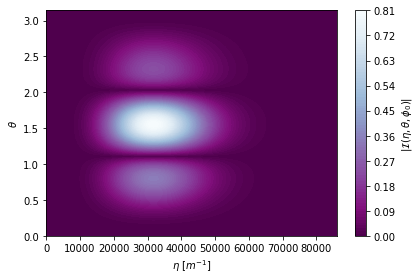

In [60]:
cname = "BuPu_r"

fig = plt.figure()
ax = fig.add_subplot(111)

mappable = ax.contourf(us, ts, integrand, 100, cmap=cname)
ax.set_xlabel("$\eta\ [m^{-1}]$")
ax.set_ylabel("$\\theta$")
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel("$|\\mathcal{I}(\\eta, \\theta, \\phi_0)|$")
plt.show()

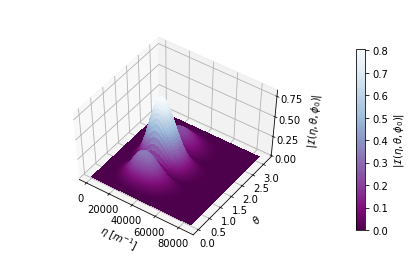

In [75]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(uu, tt, integrand, cmap=cname,
                rcount=100, ccount=100, shade=True,
                linewidth=0, antialiased=False)
ax.locator_params(axis='z', nbins=4)
ax.view_init(55, -55)
ax.dist = 13
ax.set_xlabel("$\\eta\\ [m^{-1}]$", labelpad=13)
ax.set_ylabel("$\\theta$", labelpad=12)
ax.set_zlabel("$|\\mathcal{I}(\\eta, \\theta, \\phi_0)|$", labelpad=11)
cbar = fig.colorbar(surf, ax=ax, orientation="vertical", shrink=.68)
cbar.ax.set_ylabel("$|\\mathcal{I}(\\eta, \\theta, \\phi_0)|$")
plt.show()

### $*$ The LGBeam constructor admits <i>strictly</i> the following format of parametrization only: 

In [20]:
parameters = {
    "p": 0,
    "l": 2,
    "alpha": 1,
    "beta": 0,
    "r_focus": 1E-3,
    "wavelength": 6328E-9,
    "na": .95
}

parameters["k"] = 2 * np.pi / parameters["wavelength"]
parameters["s"] = 3.2 * parameters["wavelength"]

custom_beam = LGBeam(**parameters) # Instantiation example with custom parameters
preset_beam = LGBeam()             # Instantiation with preset parameters

### Doodles

In [8]:
# how does quad integration work with scipy.integrate (as intg)?

def foo(z, y, x):
    return x + y + z

ans = intg.tplquad(foo, 0, 1, lambda x: 0, lambda x: 1, lambda x, y: 0, lambda x, y: 1)
# ans is an array, where ans[0] is the result and ans[1] is the estimated error

(1.5, 2.7707360439619496e-14)